In [232]:
import numpy as np
import pandas as pd
from fredmd import FredMD
import sklearn.pipeline as skpipe
import sklearn.decomposition as skd
import sklearn.preprocessing as skp
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg

In [233]:
from datetime import datetime

In [289]:
class SPCA:
    
    def __init__(self, Nfactor=None, vintage=None, maxfactor=8, standard_method=2, ic_method=2,
                 target=None, train_test_split=[('1960-01-01', '1984-12-01'),('1985-01-01', '2019-12-01')], 
                 nlags=1) -> None:
        """
        Create fredmd object
        Auguments:
        1) Nfactor = None: Number of factors to estimate. If None then estimate number of true factors via information critea
        2) vintage = None: Vinatege of data to use in "year-month" format (e.g. "2020-10"). If None use current vintage
        3) maxfactor = 8: Maximimum number of factors to test against information critea. If Nfactor is a number, then this is ignored
        4) standard_method = 2: method to standardize data before factors are estimate. 0 = Identity transform, 1 = Demean only, 2 = Demean and stardize to unit variance. Default = 2.
        5) ic_method = 2: information critea penalty term. See http://www.columbia.edu/~sn2294/pub/ecta02.pdf page 201, equation 9 for options.
        """
        
        self.train_test_split = [[datetime.strptime(x, '%Y-%m-%d') for x in split] for split in train_test_split]
        # Make sure arguments are valid
        if standard_method not in [0, 1, 2]:
            raise ValueError(
                f"standard_method must be in [0, 1, 2], got {standard_method}")
        if ic_method not in [1, 2, 3]:
            raise ValueError(
                f"ic_method must be in [1, 2, 3], got {ic_method}")
        # Download data
        self.rawseries, self.transforms, self.target, self.train_mask, self.test_mask = self.download_data(vintage, 
                                                                       target if target is not None else "UNRATE",
                                                                         self.train_test_split)
        if target == "UNRATE":
            self.target = self.target.diff()
        elif target == "INDPRO":
            self.target = self.target.diff()
        # Check maxfactor
        if maxfactor > self.rawseries.shape[1]:
            raise ValueError(
                f"maxfactor must be less then number of series. Maxfactor({maxfactor}) > N Series({self.rawseries.shape[1]})")

        

        self.standard_method = standard_method
        self.ic_method = ic_method
        self.maxfactor = maxfactor
        self.Nfactor = Nfactor

        self.nlags = nlags

    @staticmethod
    def download_data(vintage, tgt, train_test_split):
        if vintage is None:
            url = 'https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md/monthly/current.csv'
        else:
            url = f'https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md/monthly/{vintage}.csv'
        print(url)
        transforms = pd.read_csv(
            url, header=0, nrows=1, index_col=0).transpose()
        transforms.index.rename("series", inplace=True)
        transforms.columns = ['transform']
        transforms = transforms.to_dict()['transform']
        data = pd.read_csv(url, names=transforms.keys(), skiprows=2, index_col=0,
                           skipfooter=1, engine='python', parse_dates=True, infer_datetime_format=True)
        print(data.index)
        train_mask = (data.index > train_test_split[0][0]) & (data.index <= train_test_split[0][1])
        test_mask = (data.index > train_test_split[1][0]) & (data.index <= train_test_split[1][1])
        target = data[tgt]
        return data, transforms, target, train_mask, test_mask

    @staticmethod
    def factor_standardizer_method(code):
        """
        Outputs the sklearn standard scaler object with the desired features
        codes:
        0) Identity transform
        1) Demean only
        2) Demean and standardized
        """
        if code == 0:
            return skp.StandardScaler(with_mean=False, with_std=False)
        elif code == 1:
            return skp.StandardScaler(with_mean=True, with_std=False)
        elif code == 2:
            return skp.StandardScaler(with_mean=True, with_std=True)
        else:
            raise ValueError("standard_method must be in [0, 1, 2]")

    @staticmethod
    def data_transforms(series, transform):
        """
        Transforms a single series according to its transformation code
        Inputs:
        1) series: pandas series to be transformed
        2) transfom: transform code for the series
        Returns:
        transformed series
        """
        if transform == 1:
            # level
            return series
        elif transform == 2:
            # 1st difference
            return series.diff()
        elif transform == 3:
            # second difference
            return series.diff().diff()
        elif transform == 4:
            # Natural log
            return np.log(series)
        elif transform == 5:
            # log 1st difference
            return np.log(series).diff()
        elif transform == 6:
            # log second difference
            return np.log(series).diff().diff()
        elif transform == 7:
            # First difference of percent change
            return series.pct_change().diff()
        else:
            raise ValueError("Transform must be in [1, 2, ..., 7]")

    def apply_transforms(self):
        """
        Apply the transformation to each series to make them stationary and drop the first 2 rows that are mostly NaNs
        Save results to self.series
        """
        self.series = pd.DataFrame({key: self.data_transforms(
            self.rawseries[key], value) for (key, value) in self.transforms.items()})
        self.series.drop(self.series.index[[0, 1]], inplace=True)

    def remove_outliers(self):
        """
        Removes outliers from each series in self.series
        Outlier definition: a data point x of a series X is considered an outlier if abs(x-median)>10*interquartile_range.
        """
        Z = abs((self.series - self.series.median()) /
                (self.series.quantile(0.75) - self.series.quantile(0.25))) > 10
        for col, _ in self.series.iteritems():
            self.series[col][Z[col]] = np.nan
    
#     def rescale_matrix(self, data_mat):
        

    def factors_em(self, max_iter=50, tol=math.sqrt(0.000001)):
        """
        Estimates factors with EM alogorithm to handle missings
        Inputs:
        max_iter: Maximum number of iterations
        tol: Tolerance for convergence between iterations of predicted series values
        Alogrithm:
        1) initial_nas: Boolean mask of locations of NaNs
        2) working_data: Create Standardized data matrix with nan's replaced with means
        3) F: Preliminary factor estimates
        4) data_hat_last: Predicted standardized values of last SVD model. data_hat and data_hat_last will not exactly be mean 0 variance 1
        5) Iterate data_hat until convergence
        6) Fill in nans from orginal data
        Saves
        1) self.svdmodel: sklearn pipeline with standardization step and svd model
        2) self.series_filled: self.series with any NaNs filled in with predicted values from self.svdmodel
        """
        # Define our estimation pipelines
        self.apply_transforms()
        self.remove_outliers()
        
        pipe = skpipe.Pipeline([('Standardize', self.factor_standardizer_method(self.standard_method)),
#                                 ('Factors', skd.TruncatedSVD(self.Nfactor, algorithm='arpack'))
                               ])
        inital_scalar = self.factor_standardizer_method(self.standard_method)

        # Make numpy arrays for calculations
        actual_data = self.series.to_numpy(copy=True)
        intial_nas = self.series.isna().to_numpy(copy=True)
        working_data = inital_scalar.fit_transform(self.series.fillna(
            value=self.series.mean(), axis='index').to_numpy(copy=True))

        # Estimate initial model
        transformed_normalized_data = pipe.fit_transform(working_data)[:-1]
        evals ,evects = np.linalg.eigh(transformed_normalized_data.dot(transformed_normalized_data.T))
        tgt_data = spca.target.to_numpy()[3:]
        
        print(transformed_normalized_data.shape, tgt_data.shape)
        
        last_timestep = np.sum(self.train_mask) + np.sum(self.test_mask) - 3
#         last_timestep = -1
        
        SPCA.get_oos_r2(transformed_normalized_data[:last_timestep], 
                        tgt_data[:last_timestep], np.sum(self.train_mask)-3, self.Nfactor,
                       nlags=self.nlags)
        

    @staticmethod
    def fit_factors(scaled_data, n_factors):
        evals, evects = np.linalg.eigh(scaled_data.dot(scaled_data.T))
        factors = evects[:,-n_factors:]
        return factors
    
    @staticmethod
    def get_oos_r2(data, target, t_start, n_factors, nlags, true_oos=False):
        preds = []
        ar_preds = []
        gts = []
        
        for t in range(t_start, target.shape[0]):
            loadings = SPCA.get_gamma_is(data[:t,:], target[:t])
            if true_oos:
                fit_factors = SPCA.fit_factors(data[:t,:]*loadings, n_factors)
                test_factors = SPCA.fit_factors(data[:t+1,:]*loadings, n_factors)[t:]
            else:
                factors = SPCA.fit_factors(data[:t+1,:]*loadings, n_factors)
                fit_factors = factors[:t]
                test_factors = factors[t:]
            A_fit = np.concatenate([fit_factors, np.ones((t, 1))], axis=1)
            A_test = np.concatenate([test_factors, np.ones((1, 1))], axis=1)
            loadings = np.linalg.lstsq(A_fit, target[:t], rcond=None)[0]
            
            sim_ar_model = AutoReg(target[:t], lags=nlags, old_names=False)
            sim_ar_model_fit = sim_ar_model.fit()
            
            gts.append(target[t])
            ar_preds.append(sim_ar_model_fit.forecast())
            preds.append(A_test@loadings)
            
        preds = np.array(preds).squeeze()
        ar_preds = np.array(ar_preds).squeeze()
        print(preds.shape)
        gts = np.array(gts)
        print(gts.shape)
        plt.plot(preds - gts, label='factor resids')
        plt.plot(ar_preds - gts, label='ar resids')
        plt.legend()
        plt.show()
        print(1 - np.sum(np.square(preds - gts)) / np.sum(np.square(gts - ar_preds)))
    
    @staticmethod
    def get_gamma_is(data, target):
        loadings = []
        T = target.shape[0]
        data_copy = np.copy(data) 
        for i in range(data.shape[1]):
            A = np.stack([data[:,i], np.ones(T)], axis=1)
            loading = np.linalg.lstsq(A, target, rcond=None)[0][0]
            loadings.append(loading)
        return np.array(loadings)
        
    
    def estimate_factors(self):
        """
        Runs estimation routine.
        If number of factors is not specified then estimate the number to be used
        """
        self.apply_transforms()
        self.remove_outliers()
        self.factors_em()

https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md/monthly/current.csv
DatetimeIndex(['1959-01-01', '1959-02-01', '1959-03-01', '1959-04-01',
               '1959-05-01', '1959-06-01', '1959-07-01', '1959-08-01',
               '1959-09-01', '1959-10-01',
               ...
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', length=744, freq=None)
(741, 128) (741,)
(444,)
(444,)


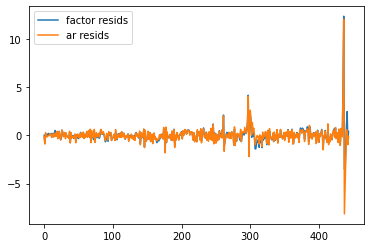

0.19207638719839615
https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md/monthly/current.csv
DatetimeIndex(['1959-01-01', '1959-02-01', '1959-03-01', '1959-04-01',
               '1959-05-01', '1959-06-01', '1959-07-01', '1959-08-01',
               '1959-09-01', '1959-10-01',
               ...
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', length=744, freq=None)
(741, 128) (741,)
(444,)
(444,)


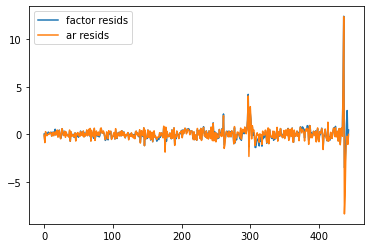

0.22163184584411622
https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md/monthly/current.csv
DatetimeIndex(['1959-01-01', '1959-02-01', '1959-03-01', '1959-04-01',
               '1959-05-01', '1959-06-01', '1959-07-01', '1959-08-01',
               '1959-09-01', '1959-10-01',
               ...
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', length=744, freq=None)
(741, 128) (741,)
(444,)
(444,)


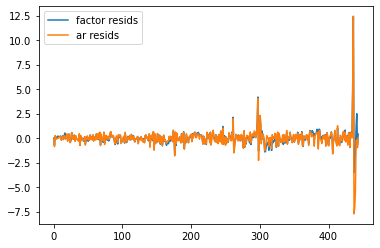

0.2546626056369228
https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md/monthly/current.csv
DatetimeIndex(['1959-01-01', '1959-02-01', '1959-03-01', '1959-04-01',
               '1959-05-01', '1959-06-01', '1959-07-01', '1959-08-01',
               '1959-09-01', '1959-10-01',
               ...
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', length=744, freq=None)
(741, 128) (741,)
(444,)
(444,)


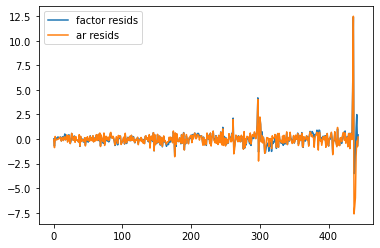

0.26165434703830004


In [288]:
for i in range(1,5):
    spca = SPCA(target='INDPRO', Nfactor=5, nlags=i)
    spca.factors_em()

https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md/monthly/current.csv
DatetimeIndex(['1959-01-01', '1959-02-01', '1959-03-01', '1959-04-01',
               '1959-05-01', '1959-06-01', '1959-07-01', '1959-08-01',
               '1959-09-01', '1959-10-01',
               ...
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', length=744, freq=None)
(741, 128) (741,)
(419,)
(419,)


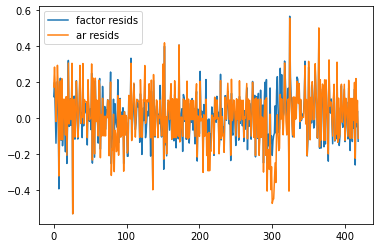

0.17968552452051945
https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md/monthly/current.csv
DatetimeIndex(['1959-01-01', '1959-02-01', '1959-03-01', '1959-04-01',
               '1959-05-01', '1959-06-01', '1959-07-01', '1959-08-01',
               '1959-09-01', '1959-10-01',
               ...
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', length=744, freq=None)
(741, 128) (741,)
(419,)
(419,)


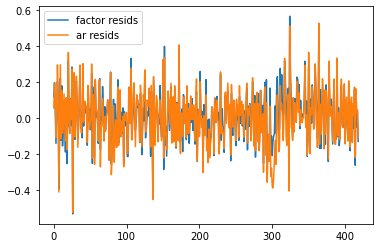

0.15295146785616398
https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md/monthly/current.csv
DatetimeIndex(['1959-01-01', '1959-02-01', '1959-03-01', '1959-04-01',
               '1959-05-01', '1959-06-01', '1959-07-01', '1959-08-01',
               '1959-09-01', '1959-10-01',
               ...
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', length=744, freq=None)
(741, 128) (741,)
(419,)
(419,)


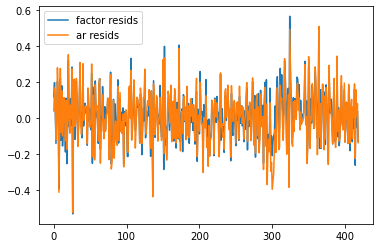

0.11409461541200283
https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md/monthly/current.csv
DatetimeIndex(['1959-01-01', '1959-02-01', '1959-03-01', '1959-04-01',
               '1959-05-01', '1959-06-01', '1959-07-01', '1959-08-01',
               '1959-09-01', '1959-10-01',
               ...
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', length=744, freq=None)
(741, 128) (741,)
(419,)
(419,)


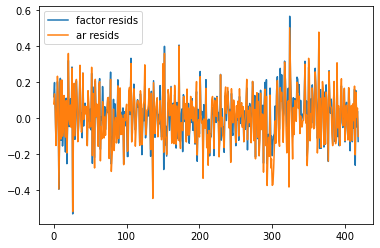

0.08904476184994436


In [286]:
for i in range(1,5):
    spca = SPCA(target='UNRATE', Nfactor=5, nlags=i)
    spca.factors_em()

(419,)
(419,)


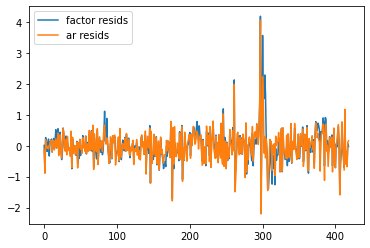

1.1511049805308506


In [261]:
spca.estimate_factors()

In [51]:
fred = FredMD()
fred.apply_transforms()
fred.remove_outliers()

https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md/monthly/current.csv


In [47]:
fred.Nfactor = 10

In [53]:
pipe = skpipe.Pipeline([('Standardize', fred.factor_standardizer_method(fred.standard_method)),
#                        ('Factors', skd.TruncatedSVD(fred.Nfactor, algorithm='arpack'))
                       ])
actual_data = fred.series.to_numpy(copy=True)
intial_nas = fred.series.isna().to_numpy(copy=True)
inital_scalar = fred.factor_standardizer_method(fred.standard_method)
working_data = inital_scalar.fit_transform(fred.series.fillna(value=fred.series.mean(), 
                                                              axis='index').to_numpy(copy=True))
data = pipe.fit_transform(working_data)

In [56]:
data.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [57]:
eig_vals, eig_vects = np.linalg.eigh(standardized_data.T.dot(standardized_data))

In [61]:
eig_vals / np.sum(np.sum(eig_vals))

array([2.97965257e-07, 2.39278045e-06, 4.02957477e-06, 7.54408789e-06,
       8.75060145e-06, 1.34836161e-05, 1.49403480e-05, 1.82120372e-05,
       2.02276488e-05, 2.08989927e-05, 2.37548150e-05, 3.43286195e-05,
       4.73844401e-05, 5.09838978e-05, 5.44298063e-05, 8.73096264e-05,
       8.79316945e-05, 1.06109755e-04, 1.15320997e-04, 1.25272737e-04,
       1.33914087e-04, 1.58441904e-04, 1.70246149e-04, 2.16338508e-04,
       2.25279789e-04, 2.43188657e-04, 2.71799304e-04, 2.86879126e-04,
       3.08745339e-04, 3.26165190e-04, 3.70156279e-04, 3.94748709e-04,
       4.09264088e-04, 4.13690088e-04, 4.71690193e-04, 4.92526268e-04,
       5.35951731e-04, 5.62665728e-04, 5.82337018e-04, 6.43025749e-04,
       6.78708567e-04, 7.83484743e-04, 8.20438633e-04, 8.46733779e-04,
       8.65212383e-04, 9.79524846e-04, 1.00014017e-03, 1.05328578e-03,
       1.08172866e-03, 1.13643886e-03, 1.19671447e-03, 1.26478821e-03,
       1.31526694e-03, 1.48000765e-03, 1.54115947e-03, 1.57587893e-03,
      